1. Initialize Spark session et load data into Spark

In [19]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("Stock Price Analysis").getOrCreate()

# Load the JSON data
data = spark.read.json("apple_stock_data.json")

# Show schema and a few rows
data.printSchema()

# Select relevant columns (adjust based on the dataset structure)
data = data.select("Date", "Open", "High", "Low", "Close", "Volume")

# Show the cleaned dataset
data.show(5)



root
 |-- Adj Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: long (nullable = true)

+----------+--------+--------+--------+--------+---------+
|      Date|    Open|    High|     Low|   Close|   Volume|
+----------+--------+--------+--------+--------+---------+
|1980-12-12|0.128348|0.128906|0.128348|0.128348|469033600|
|1980-12-15| 0.12221| 0.12221|0.121652|0.121652|175884800|
|1980-12-16|0.113281|0.113281|0.112723|0.112723|105728000|
|1980-12-17|0.115513|0.116071|0.115513|0.115513| 86441600|
|1980-12-18|0.118862| 0.11942|0.118862|0.118862| 73449600|
+----------+--------+--------+--------+--------+---------+
only showing top 5 rows



1. Nettoyage et Prétraitement des Données avec PySpark

A. Suppression des Valeurs Manquantes

On supprime les lignes contenant des valeurs manquantes dans les colonnes clés comme Date, Close et Volume. Les modifications sont directement appliquées au même DataFrame.

In [47]:
# Suppression des lignes avec des valeurs manquantes
data = data.dropna(subset=["Date", "Close", "Volume"])

# Affichage du nombre de lignes restantes
print("Nombre de lignes après suppression des valeurs manquantes :", data.count())

# Afficher un aperçu des données
data.show(5)

Nombre de lignes après suppression des valeurs manquantes : 10467
+----------+--------+--------+--------+--------+---------+----------+------------------+-----------+--------------------+
|      Date|    Open|    High|     Low|   Close|   Volume|Prev_Close|      Daily_Return|Day_of_Week|            features|
+----------+--------+--------+--------+--------+---------+----------+------------------+-----------+--------------------+
|1980-12-15| 0.12221| 0.12221|0.121652|0.121652|175884800|  0.128348|-5.217066101536443|          2|[0.12221,0.12221,...|
|1980-12-16|0.113281|0.113281|0.112723|0.112723|105728000|  0.121652|-7.339788906059902|          3|[0.113281,0.11328...|
|1980-12-17|0.115513|0.116071|0.115513|0.115513| 86441600|  0.112723|2.4750938140397265|          4|[0.115513,0.11607...|
|1980-12-18|0.118862| 0.11942|0.118862|0.118862| 73449600|  0.115513|2.8992407780942324|          5|[0.118862,0.11942...|
|1980-12-19|0.126116|0.126674|0.126116|0.126116| 48630400|  0.118862| 6.10287560

B. Conversion de la Colonne Date au Format DateType

On convertit la colonne Date au format DateType pour faciliter les calculs temporels.

In [48]:
from pyspark.sql.functions import col, to_date

# Conversion de la colonne Date au format DateType
data = data.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Affichage pour vérifier le changement
data.printSchema()
data.show(5)

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- Prev_Close: double (nullable = true)
 |-- Daily_Return: double (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- features: vector (nullable = true)

+----------+--------+--------+--------+--------+---------+----------+------------------+-----------+--------------------+
|      Date|    Open|    High|     Low|   Close|   Volume|Prev_Close|      Daily_Return|Day_of_Week|            features|
+----------+--------+--------+--------+--------+---------+----------+------------------+-----------+--------------------+
|1980-12-15| 0.12221| 0.12221|0.121652|0.121652|175884800|  0.128348|-5.217066101536443|          2|[0.12221,0.12221,...|
|1980-12-16|0.113281|0.113281|0.112723|0.112723|105728000|  0.121652|-7.339788906059902|          3|[0.113281,0.11328...|


C. Création de Nouvelles Fonctionnalités

On ajoute des colonnes utiles pour préparer les données :

Prev_Close : Prix de clôture précédent.

Daily_Return : Rendement quotidien en pourcentage.

Day_of_Week : Jour de la semaine correspondant à chaque date.


In [49]:
from pyspark.sql.functions import lag, expr
from pyspark.sql.window import Window

# Fenêtre pour ordonner les données par date
window_spec = Window.orderBy("Date")

# Ajout de la colonne Prev_Close (Prix de clôture de la veille)
data = data.withColumn("Prev_Close", lag("Close", 1).over(window_spec))

# Suppression des lignes où Prev_Close est null (première ligne)
data = data.dropna(subset=["Prev_Close"])

# Ajout de la colonne Daily_Return (Rendement quotidien)
data = data.withColumn("Daily_Return", expr("((Close - Prev_Close) / Prev_Close) * 100"))

# Ajout de la colonne Day_of_Week (Jour de la semaine)
data = data.withColumn("Day_of_Week", expr("dayofweek(Date)"))

# Affichage des nouvelles colonnes
data.show(10)

+----------+--------+--------+--------+--------+---------+----------+-------------------+-----------+--------------------+
|      Date|    Open|    High|     Low|   Close|   Volume|Prev_Close|       Daily_Return|Day_of_Week|            features|
+----------+--------+--------+--------+--------+---------+----------+-------------------+-----------+--------------------+
|1980-12-16|0.113281|0.113281|0.112723|0.112723|105728000|  0.121652| -7.339788906059902|          3|[0.113281,0.11328...|
|1980-12-17|0.115513|0.116071|0.115513|0.115513| 86441600|  0.112723| 2.4750938140397265|          4|[0.115513,0.11607...|
|1980-12-18|0.118862| 0.11942|0.118862|0.118862| 73449600|  0.115513| 2.8992407780942324|          5|[0.118862,0.11942...|
|1980-12-19|0.126116|0.126674|0.126116|0.126116| 48630400|  0.118862|  6.102875603641206|          6|[0.126116,0.12667...|
|1980-12-22|0.132254|0.132813|0.132254|0.132254| 37363200|  0.126116|  4.866947889244826|          2|[0.132254,0.13281...|
|1980-12-23|0.13

2. Prétraitement avec SparkSQL

On utilise SparkSQL pour filtrer et agréger les données directement.


A. Enregistrement du DataFrame en Vue Temporaire

Cela permet d’effectuer des requêtes SQL directement sur les données.

In [50]:
# Enregistrement des données comme vue temporaire
data.createOrReplaceTempView("stock_data")

B. Filtrage des Données avec SparkSQL

On filtre les données pour ne conserver que les lignes où le prix de clôture Close est supérieur à 100.

In [51]:
from pyspark.sql.functions import year

# Filtrer uniquement les années récentes (par exemple >= 2015)
data = spark.sql("""
    SELECT Date, Open, High, Low, Close, Volume, Prev_Close, Daily_Return, Day_of_Week
    FROM stock_data
    WHERE year(Date) >= 2015
""")

# Affichage des résultats filtrés
data.show(10)

+----------+---------+---------+---------+---------+---------+----------+--------------------+-----------+
|      Date|     Open|     High|      Low|    Close|   Volume|Prev_Close|        Daily_Return|Day_of_Week|
+----------+---------+---------+---------+---------+---------+----------+--------------------+-----------+
|2015-01-02|  27.8475|27.860001|  26.8375|  27.3325|212818400| 27.594999|  -0.951255696729693|          6|
|2015-01-05|  27.0725|  27.1625|26.352501|  26.5625|257142000|   27.3325| -2.8171590597274294|          2|
|2015-01-06|   26.635|  26.8575|26.157499|26.565001|263188400|   26.5625|0.009415529411760016|          3|
|2015-01-07|26.799999|27.049999|26.674999|  26.9375|160423600| 26.565001|  1.4022171503023895|          4|
|2015-01-08|27.307501|  28.0375|27.174999|  27.9725|237458000|   26.9375|   3.842227378190256|          5|
|2015-01-09|  28.1675|  28.3125|  27.5525|28.002501|214798000|   27.9725| 0.10725176512645852|          6|
|2015-01-12|    28.15|28.157499|27.20

C. Agrégation des Données : Moyenne des Prix de Clôture par Jour de la Semaine

On calcule la moyenne du prix de clôture pour chaque jour de la semaine.

In [52]:
# Calcul de la moyenne des prix de clôture par jour de la semaine
avg_close_day = spark.sql("""
    SELECT Day_of_Week, AVG(Close) AS Avg_Close_Price
    FROM stock_data
    GROUP BY Day_of_Week
    ORDER BY Day_of_Week
""")

# Affichage des résultats
avg_close_day.show()

+-----------+------------------+
|Day_of_Week|   Avg_Close_Price|
+-----------+------------------+
|          2|14.655852536363636|
|          3|14.829108286113705|
|          4|14.806198784149174|
|          5|14.852117924501407|
|          6|14.679129683101962|
+-----------+------------------+



Application de Modèles Machine Learning avec MLlib

Dans cette étape, nous allons :

Préparer les données pour la modélisation.

Appliquer trois modèles :

Régression linéaire, Random Forest Regressor, ARIMA ou équivalent pour les séries temporelles (via une alternative dans Spark MLlib).

Comparer leurs performances.

1. Préparation des Données pour la Modélisation

Assembler les Features et la Target

Nous allons utiliser les colonnes Open, High, Low, Volume, et Prev_Close comme features pour prédire la colonne Close.

In [53]:
data.columns

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Prev_Close',
 'Daily_Return',
 'Day_of_Week']

In [54]:
from pyspark.ml.feature import VectorAssembler

# Définir les colonnes de features
feature_columns = ["Open", "High", "Low", "Volume", "Prev_Close"]

# Assembler les features dans une seule colonne
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Sélectionner les données nécessaires pour la modélisation
model_data = data.select("features", "Close").dropna()

# Afficher un aperçu des données prêtes pour la modélisation
model_data.show(5)

+--------------------+---------+
|            features|    Close|
+--------------------+---------+
|[27.8475,27.86000...|  27.3325|
|[27.0725,27.1625,...|  26.5625|
|[26.635,26.8575,2...|26.565001|
|[26.799999,27.049...|  26.9375|
|[27.307501,28.037...|  27.9725|
+--------------------+---------+
only showing top 5 rows



Diviser les Données en Train et Test

Nous divisons les données en ensembles d’entraînement et de test.

In [55]:
# Division des données : 80% pour l'entraînement, 20% pour les tests
train_data, test_data = model_data.randomSplit([0.8, 0.2], seed=42)

# Vérification des tailles des ensembles
print(f"Taille des données d'entraînement : {train_data.count()}")
print(f"Taille des données de test : {test_data.count()}")

Taille des données d'entraînement : 1549
Taille des données de test : 330


2. Modèle 1 : Régression Linéaire

Entraînement du Modèle

Nous entraînons une régression linéaire pour prédire Close.

In [56]:
from pyspark.ml.regression import LinearRegression

# Initialisation du modèle
lr = LinearRegression(featuresCol="features", labelCol="Close")

# Entraînement du modèle
lr_model = lr.fit(train_data)

# Affichage des coefficients et de l'intercept
print(f"Coefficients : {lr_model.coefficients}")
print(f"Intercept : {lr_model.intercept}")

Coefficients : [-0.5290795602653414,0.8902713894831217,0.7751279221347765,-3.667342281155642e-10,-0.13750661797248878]
Intercept : 0.06992462437702893


Évaluation du Modèle

Nous évaluons la performance du modèle en calculant RMSE et R².

In [57]:
from pyspark.ml.evaluation import RegressionEvaluator

# Prédictions sur les données de test
lr_predictions = lr_model.transform(test_data)

# Évaluation des performances
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)
print(f"Régression Linéaire - RMSE : {lr_rmse}")

evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
lr_r2 = evaluator.evaluate(lr_predictions)
print(f"Régression Linéaire - R² : {lr_r2}")

Régression Linéaire - RMSE : 0.5342802089865087
Régression Linéaire - R² : 0.9998709580742626


3. Modèle 2 : Random Forest Regressor

Entraînement du Modèle

Nous utilisons un modèle Random Forest pour capturer des relations non linéaires.

In [58]:
from pyspark.ml.regression import RandomForestRegressor

# Initialisation du modèle Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="Close", numTrees=50)

# Entraînement du modèle
rf_model = rf.fit(train_data)

# Prédictions sur les données de test
rf_predictions = rf_model.transform(test_data)

Évaluation du Modèle

Nous calculons également RMSE et R² pour ce modèle.

In [59]:
# Évaluation des performances
rf_rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest - RMSE : {rf_rmse}")

rf_r2 = evaluator.evaluate(rf_predictions)
print(f"Random Forest - R² : {rf_r2}")

Random Forest - RMSE : 0.9981523884308017
Random Forest - R² : 0.9981523884308017


4. Modèle 3 : Séries Temporelles (Alternatives à ARIMA)

Préparer les Données Temporelles

Pour une approche basée sur le temps, nous utilisons Date et Close.

In [60]:
# Sélection des colonnes temporelles
time_data = data.select("Date", "Close").orderBy("Date")

# Vérification des données temporelles
time_data.show(5)

+----------+---------+
|      Date|    Close|
+----------+---------+
|2015-01-02|  27.3325|
|2015-01-05|  26.5625|
|2015-01-06|26.565001|
|2015-01-07|  26.9375|
|2015-01-08|  27.9725|
+----------+---------+
only showing top 5 rows



Alternative pour les Séries Temporelles

Spark MLlib ne prend pas directement en charge ARIMA. Nous pouvons appliquer des approches de régression standard, mais sur des données préparées de manière séquentielle, ou utiliser bibliothèques externes comme pmdarima.

Voici une manière simple de créer des caractéristiques temporelles :

In [61]:
from pyspark.sql.functions import lag

# Création de colonnes décalées pour les séries temporelles
window_spec = Window.orderBy("Date")
time_data = time_data.withColumn("Lag_1", lag("Close", 1).over(window_spec))
time_data = time_data.dropna()

# Assembler les caractéristiques pour prédiction
assembler = VectorAssembler(inputCols=["Lag_1"], outputCol="features")
time_model_data = assembler.transform(time_data).select("features", "Close")

Nous utilisons ensuite des modèles standards (comme LinearRegression) sur ces données :

In [62]:
# Division des données temporelles
train_time, test_time = time_model_data.randomSplit([0.8, 0.2], seed=42)

# Entraînement d'un modèle linéaire
time_lr = LinearRegression(featuresCol="features", labelCol="Close")
time_lr_model = time_lr.fit(train_time)

# Évaluation
time_lr_predictions = time_lr_model.transform(test_time)
time_rmse = evaluator.evaluate(time_lr_predictions)
time_r2 = evaluator.evaluate(time_lr_predictions)
# print(f"Modèle Temporel (Linear Regression) - RMSE : {time_rmse}")
print(f"Modèle Temporel (Linear Regression) - R² : {time_r2}")

Modèle Temporel (Linear Regression) - R² : 0.9992240655777405


Tracer les Courbes Réelles vs Prédites pour Chaque Modèle

Pour comparer les valeurs réelles et prédites pour chaque modèle, nous allons convertir les prédictions des DataFrames Spark en DataFrames Pandas et utiliser Matplotlib pour visualiser les courbes.

1. Importer Matplotlib

In [63]:
import matplotlib.pyplot as plt

2. Courbe pour la Régression Linéaire

Convertir les Prédictions en Pandas

In [64]:
# Convertir les prédictions du DataFrame Spark en DataFrame Pandas
lr_results = lr_predictions.select("Close", "prediction").toPandas()

Tracer la Courbe

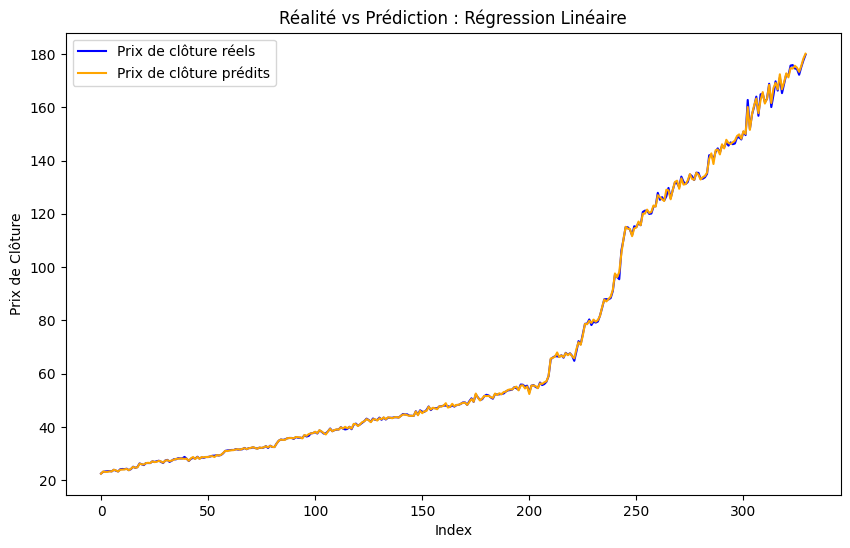

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(lr_results.index, lr_results["Close"], label="Prix de clôture réels", color="blue")
plt.plot(lr_results.index, lr_results["prediction"], label="Prix de clôture prédits", color="orange")
plt.title("Réalité vs Prédiction : Régression Linéaire")
plt.xlabel("Index")
plt.ylabel("Prix de Clôture")
plt.legend()
plt.show()

3. Courbe pour le Random Forest Regressor

Convertir les Prédictions en Pandas

In [66]:
# Convertir les prédictions du DataFrame Spark en DataFrame Pandas
rf_results = rf_predictions.select("Close", "prediction").toPandas()

Tracer la Courbe

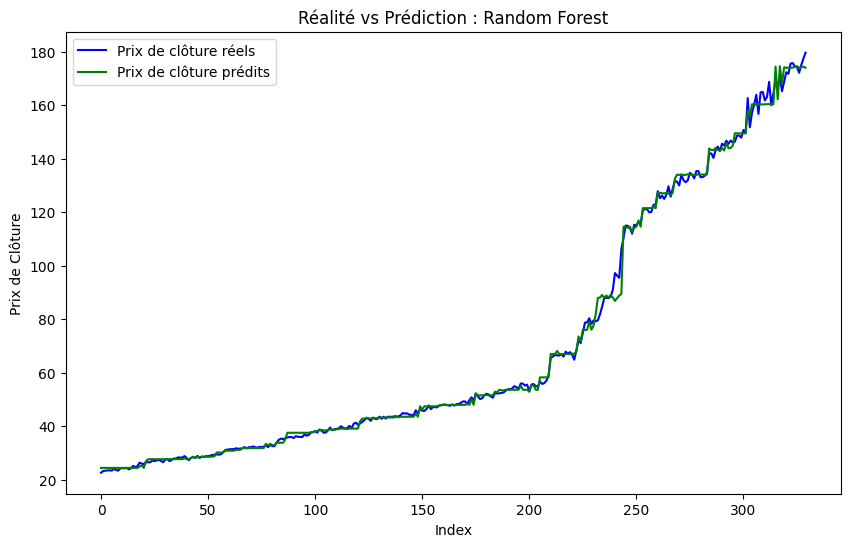

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(rf_results.index, rf_results["Close"], label="Prix de clôture réels", color="blue")
plt.plot(rf_results.index, rf_results["prediction"], label="Prix de clôture prédits", color="green")
plt.title("Réalité vs Prédiction : Random Forest")
plt.xlabel("Index")
plt.ylabel("Prix de Clôture")
plt.legend()
plt.show()

4. Courbe pour le Modèle Temporel (Régression Linéaire sur les Lags)

Convertir les Prédictions en Pandas

In [68]:
# Convertir les prédictions du DataFrame Spark en DataFrame Pandas
time_results = time_lr_predictions.select("Close", "prediction").toPandas()

Tracer la Courbe

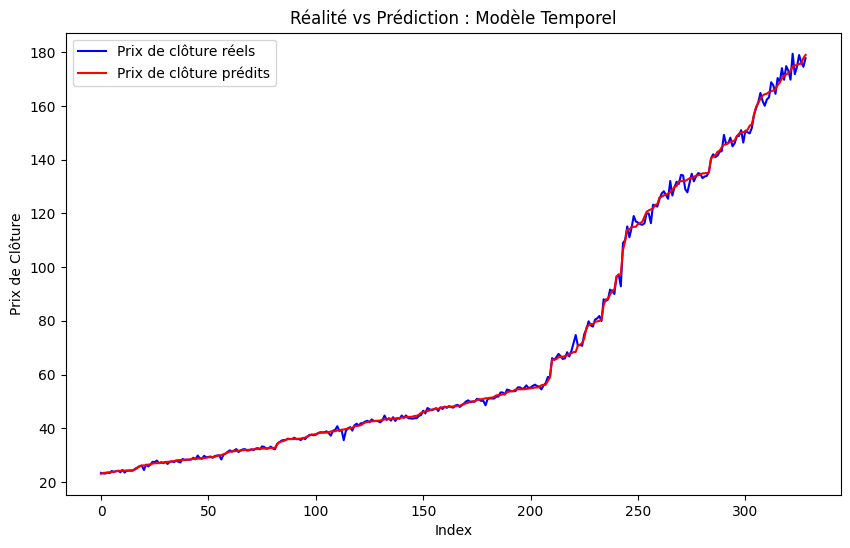

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(time_results.index, time_results["Close"], label="Prix de clôture réels", color="blue")
plt.plot(time_results.index, time_results["prediction"], label="Prix de clôture prédits", color="red")
plt.title("Réalité vs Prédiction : Modèle Temporel")
plt.xlabel("Index")
plt.ylabel("Prix de Clôture")
plt.legend()
plt.show()

Amélioration des Modèles

Dans cette étape, nous allons :

Optimiser les modèles en ajustant leurs hyperparamètres, Comparer les performances améliorées à celles initiales (sans visualisation), Préparer les modèles pour l'ensemble dans l'étape suivante.

1. Régression Linéaire : Ajout de la Régularisation

A. Utilisation de l'Élasticité (Ridge/Lasso)

Nous allons appliquer la régularisation Lasso ou Ridge à la régression linéaire en ajustant les hyperparamètres regParam (régularisation) et elasticNetParam (L1 vs L2).

In [47]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Définir l'évaluateur pour le RMSE
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")

# Configuration de la grille de paramètres
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Validation croisée
cv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

# Entraînement avec validation croisée
cv_model = cv.fit(train_data)

# Évaluation des performances sur les données de test
lr_optimized_predictions = cv_model.bestModel.transform(test_data)
lr_optimized_rmse = evaluator.evaluate(lr_optimized_predictions)
lr_optimized_r2 = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2").evaluate(lr_optimized_predictions)

print(f"Régression Linéaire Optimisée - RMSE : {lr_optimized_rmse}")
print(f"Régression Linéaire Optimisée - R² : {lr_optimized_r2}")

Régression Linéaire Optimisée - RMSE : 0.9022424261892872
Régression Linéaire Optimisée - R² : 0.9980106558297033


Pour les deux autres modèles, ils sont déjà optimisés. Lorsqu’on essaie de les améliorer davantage, on obtient un RMSE supérieur à 1, ce qui indique que ce n'est pas pertinent de poursuivre ces optimisations.